We explore predicting the confidence levels of forest fires with a Random Forest Regressor
Confidence levels can be:l = low, n = nominal, and h = high

In [2]:
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Read dataset which was extracted from NASA site as 10 csv files and combined into one csv 
df = pd.read_csv("tnt_fires.csv")

In [4]:
df.head()

,Unnamed: 0,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight,type,year,month,day
0,0,2.450549,-59.424458,335.22,0.43,0.38,2012-01-20,1730,N,VIIRS,n,1,295.35,2.43,D,0,2012,1,20
1,1,2.501183,-59.738789,332.34,0.42,0.38,2012-01-20,1730,N,VIIRS,n,1,297.51,4.54,D,0,2012,1,20
2,2,2.490773,-59.737251,337.09,0.42,0.38,2012-01-20,1730,N,VIIRS,n,1,290.36,13.91,D,0,2012,1,20
3,3,2.493114,-59.745358,348.79,0.42,0.38,2012-01-20,1730,N,VIIRS,n,1,298.69,8.35,D,0,2012,1,20
4,4,2.490209,-59.741047,337.00,0.42,0.38,2012-01-20,1730,N,VIIRS,n,1,293.50,8.35,D,0,2012,1,20


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88126 entries, 0 to 88125
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  88126 non-null  int64  
 1   latitude    88126 non-null  float64
 2   longitude   88126 non-null  float64
 3   bright_ti4  88126 non-null  float64
 4   scan        88126 non-null  float64
 5   track       88126 non-null  float64
 6   acq_date    88126 non-null  object 
 7   acq_time    88126 non-null  int64  
 8   satellite   88126 non-null  object 
 9   instrument  88126 non-null  object 
 10  confidence  88126 non-null  object 
 11  version     88126 non-null  int64  
 12  bright_ti5  88126 non-null  float64
 13  frp         88126 non-null  float64
 14  daynight    88126 non-null  object 
 15  type        88126 non-null  int64  
 16  year        88126 non-null  int64  
 17  month       88126 non-null  int64  
 18  day         88126 non-null  int64  
dtypes: float64(7), int64(7), 

In [6]:
df.columns

Index(['Unnamed: 0', 'latitude', 'longitude', 'bright_ti4', 'scan', 'track',
       'acq_date', 'acq_time', 'satellite', 'instrument', 'confidence',
       'version', 'bright_ti5', 'frp', 'daynight', 'type', 'year', 'month',
       'day'],
      dtype='object')

In [7]:
df.describe()

,Unnamed: 0,latitude,longitude,bright_ti4,scan,track,acq_time,version,bright_ti5,frp,type,year,month,day
count,88126.000000,88126.000000,88126.000000,88126.000000,88126.000000,88126.000000,88126.000000,88126.0,88126.000000,88126.000000,88126.000000,88126.000000,88126.000000,88126.000000
mean,4680.103261,4.804430,-58.973473,336.599316,0.451238,0.463002,1592.048953,1.0,296.076735,7.136663,0.042360,2016.332694,6.821687,15.814175
std,2950.379757,1.678266,0.960230,12.463306,0.078131,0.104039,361.219381,0.0,6.200262,8.765795,0.353894,2.687061,3.859260,8.665437
min,0.000000,1.542446,-61.324394,208.000000,0.320000,0.360000,426.000000,1.0,244.880000,0.060000,0.000000,2012.000000,1.000000,1.000000
25%,2203.000000,3.293508,-59.658293,331.600000,0.390000,0.380000,1652.000000,1.0,292.170000,3.230000,0.000000,2014.000000,3.000000,8.000000
50%,4427.000000,4.800262,-59.342075,336.560000,0.430000,0.430000,1717.000000,1.0,296.420000,5.080000,0.000000,2016.000000,9.000000,16.000000
75%,6875.000000,6.319916,-57.993775,343.020000,0.500000,0.530000,1736.000000,1.0,300.200000,8.080000,0.000000,2019.000000,10.000000,23.000000
max,12805.000000,8.387190,-57.141369,367.000000,0.800000,0.780000,1825.000000,1.0,376.410000,479.130000,3.000000,2021.000000,12.000000,31.000000


<AxesSubplot:>

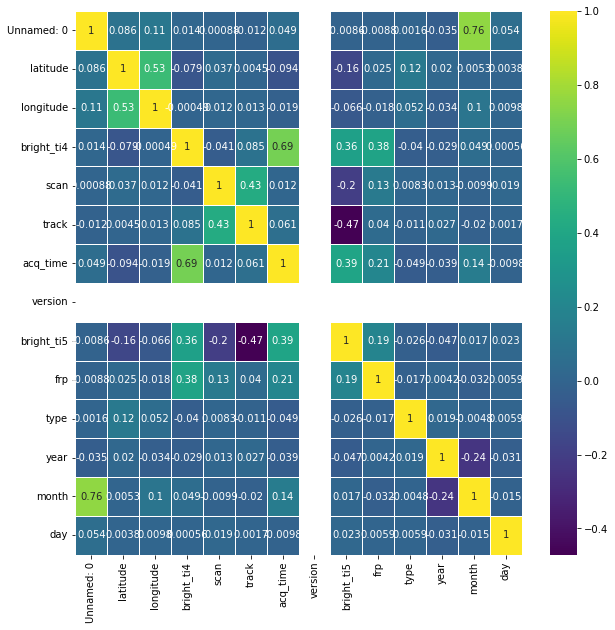

In [8]:
# Plot heatmap showing correlation
plt.figure(figsize = (10,10))
sns.heatmap(df.corr(), annot = True, cmap = "viridis", linewidths = 0.5)

## Data Cleaning

In [9]:
# Drop track column???
df = df.drop(["track"], axis = 1)

In [10]:
# Find Categorical Data
for col in df.columns:
    print("The {} column".format(col))
    print(df[col].value_counts())
    print("*****")

The Unnamed: 0 column
0        10
2799     10
2801     10
2802     10
2803     10
         ..
11270     1
11269     1
11268     1
11267     1
12805     1
Name: Unnamed: 0, Length: 12806, dtype: int64
*****
The latitude column
6.438489    3
3.617743    3
3.715153    3
5.870817    3
2.970873    3
           ..
2.611409    1
3.133358    1
3.136161    1
3.722429    1
3.116523    1
Name: latitude, Length: 87116, dtype: int64
*****
The longitude column
-59.560097    6
-59.579220    6
-59.585579    6
-59.534805    6
-59.365517    5
             ..
-57.663727    1
-59.535213    1
-59.534824    1
-59.534367    1
-59.680115    1
Name: longitude, Length: 76939, dtype: int64
*****
The bright_ti4 column
367.00    3133
332.51      73
335.48      71
331.60      70
330.12      69
          ... 
298.41       1
300.35       1
299.27       1
297.65       1
306.90       1
Name: bright_ti4, Length: 5619, dtype: int64
*****
The scan column
0.39    12064
0.40     6631
0.41     5663
0.42     5503
0.43     519

In [11]:
# Remove columns with one value since they can not help in the prediction
df = df.drop(["satellite", "instrument", "version"], axis = 1)

In [12]:
df.daynight.unique()

array(['D', 'N', '0', '1'], dtype=object)

In [13]:
# Change categorical data using mapping method
confidence_map = {'l': 0, 'n': 1, 'h': 2}
daynight_map = {'D': 1, 'N': 0, '1': 1, '0': 0}

df["confidence"] = df["confidence"].map(confidence_map)
df["daynight"] = df["daynight"].map(daynight_map)

In [14]:
df.daynight.unique()

array([1, 0], dtype=int64)

In [15]:
# Change fire type to one-hot ecoding columns using get dummies
types = pd.get_dummies(df["type"])
df = pd.concat([df, types], axis = 1)

df = df.drop(["type"], axis = 1)

df.head()

,Unnamed: 0,latitude,longitude,bright_ti4,scan,acq_date,acq_time,confidence,bright_ti5,frp,daynight,year,month,day,0,2,3
0,0,2.450549,-59.424458,335.22,0.43,2012-01-20,1730,1,295.35,2.43,1,2012,1,20,1,0,0
1,1,2.501183,-59.738789,332.34,0.42,2012-01-20,1730,1,297.51,4.54,1,2012,1,20,1,0,0
2,2,2.490773,-59.737251,337.09,0.42,2012-01-20,1730,1,290.36,13.91,1,2012,1,20,1,0,0
3,3,2.493114,-59.745358,348.79,0.42,2012-01-20,1730,1,298.69,8.35,1,2012,1,20,1,0,0
4,4,2.490209,-59.741047,337.00,0.42,2012-01-20,1730,1,293.50,8.35,1,2012,1,20,1,0,0


In [16]:
# Rename type columns
df = df.rename(columns = {0: "land_fire", 2: "static_fire", 3: "offshore_fire"})

Data binning, also called discrete binning or bucketing, is a data pre-processing technique used to reduce the effects of minor observation errors. The original data values which fall into a given small interval, a bin, are replaced by a value representative of that interval, often the central value

In [17]:
# Convert scan column to categorical type. I might not use this if the value is only 1
#bins = [0, 1, 2, 3, 4, 5]
#labels = [1,2,3,4,5]
#df['scan_binned'] = pd.cut(df['scan'], bins=bins, labels=labels)

In [18]:
# Convert date into datetype
df["acq_date"] = pd.to_datetime(df["acq_date"])

# Drop scan column. not for this code
#df = df.drop(["scan"], axis = 1)

In [19]:
# Create a column for year, month and day
df["year"] = df["acq_date"].dt.year
df["month"] = df["acq_date"].dt.month
df["day"] = df["acq_date"].dt.day

df.head()

,Unnamed: 0,latitude,longitude,bright_ti4,scan,acq_date,acq_time,confidence,bright_ti5,frp,daynight,year,month,day,land_fire,static_fire,offshore_fire
0,0,2.450549,-59.424458,335.22,0.43,2012-01-20,1730,1,295.35,2.43,1,2012,1,20,1,0,0
1,1,2.501183,-59.738789,332.34,0.42,2012-01-20,1730,1,297.51,4.54,1,2012,1,20,1,0,0
2,2,2.490773,-59.737251,337.09,0.42,2012-01-20,1730,1,290.36,13.91,1,2012,1,20,1,0,0
3,3,2.493114,-59.745358,348.79,0.42,2012-01-20,1730,1,298.69,8.35,1,2012,1,20,1,0,0
4,4,2.490209,-59.741047,337.00,0.42,2012-01-20,1730,1,293.50,8.35,1,2012,1,20,1,0,0


In [20]:
df.isna().sum()

Unnamed: 0       0
latitude         0
longitude        0
bright_ti4       0
scan             0
acq_date         0
acq_time         0
confidence       0
bright_ti5       0
frp              0
daynight         0
year             0
month            0
day              0
land_fire        0
static_fire      0
offshore_fire    0
dtype: int64

array([[<AxesSubplot:title={'center':'Unnamed: 0'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'bright_ti4'}>],
       [<AxesSubplot:title={'center':'scan'}>,
        <AxesSubplot:title={'center':'acq_date'}>,
        <AxesSubplot:title={'center':'acq_time'}>,
        <AxesSubplot:title={'center':'confidence'}>],
       [<AxesSubplot:title={'center':'bright_ti5'}>,
        <AxesSubplot:title={'center':'frp'}>,
        <AxesSubplot:title={'center':'daynight'}>,
        <AxesSubplot:title={'center':'year'}>],
       [<AxesSubplot:title={'center':'month'}>,
        <AxesSubplot:title={'center':'day'}>,
        <AxesSubplot:title={'center':'land_fire'}>,
        <AxesSubplot:title={'center':'static_fire'}>],
       [<AxesSubplot:title={'center':'offshore_fire'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

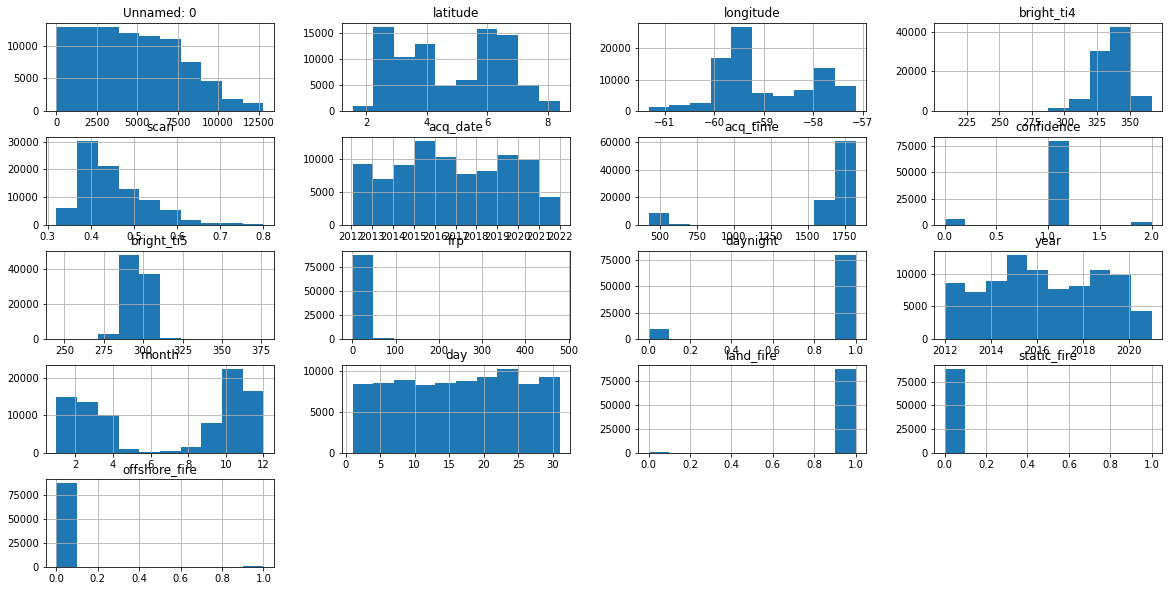

In [21]:
df.hist(figsize=(20,10))

From charts we can tell:

    Most of the fires detected is between January and May which is within our dry season
    There were more fires classified with nominal confidence which means there was glint affecting the reading
    There were more type 0 fires detected which is vegetation/forest



In [22]:
# Get feature labels
features = ["latitude", "longitude", "scan", "frp", "daynight", "land_fire","static_fire", "offshore_fire", "year", "month", "day"]

# Separating out the target
X = df.loc[:, features].values 
y = df.loc[:,["confidence"]].values.ravel() 

In [23]:
# Oversample the data to correct the imbalance in stroke victims
count = Counter( y)
print("Before oversampling: {}".format(count))

sm = SMOTE(random_state = 100)

X_sm, y_sm = sm.fit_resample(X, y)

count = Counter( y_sm)
print("After oversampling: {}".format(count))

Before oversampling: Counter({1: 79571, 0: 5826, 2: 2729})
After oversampling: Counter({1: 79571, 2: 79571, 0: 79571})


In [24]:
# 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state = 42) 

In [25]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (167099, 11)
Training Labels Shape: (167099,)
Testing Features Shape: (71614, 11)
Testing Labels Shape: (71614,)


In [26]:
# The baseline predictions against land (forest) fires (we need to beat)
baseline_preds = X_test[:, features.index('land_fire')] 

# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - y_test)

print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  0.67


In [27]:
# Build a random forest regressor model with 300 decision trees
rfg = RandomForestRegressor(n_estimators = 300, random_state = 42)

In [28]:
# Train the model
rfg.fit(X_train, y_train)

# Make predictions on test data
y_pred = rfg.predict(X_test)

# Calculate the absolute errors
errors = abs(y_pred - y_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.14 degrees.


In [ ]:
#import pickle
# Pickle model by serializing and saving it
pickle.dump(rfg, open("rfg_model.pkl", "wb"))

#to depickle or load model
#rfg_model = pickle.load(open("rfg_model.pkl", "rb"))

#Use model to predict
#print(model.predict([[1.8]]))

In [29]:
# Check accuracy
accuracy1 = round(rfg.score(X_train, y_train) * 100,2) #99.33
print("Model train accuracy:", accuracy1)


accuracy2 = round(rfg.score(X_test, y_test) * 100,2) 
print("Model test accuracy:", accuracy2)

Model train accuracy: 98.49
Model test accuracy: 88.96


In [30]:
# Calculate and print metics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.14487334878655012
Mean Squared Error: 0.0738612673499595
Root Mean Squared Error: 0.2717742948660883
